In [3]:
import pandas as pd
import json

# === STEP 1: Load JSON File ===
with open("user-wallet-transactions.json", "r") as f:
    raw_data = json.load(f)

# === STEP 2: Flatten the Nested JSON ===
df = pd.json_normalize(raw_data)

# === STEP 3: Convert Timestamp ===
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# === STEP 4: Convert amount and asset price to float ===
df['actionData.amount'] = df['actionData.amount'].astype(float)
df['actionData.assetPriceUSD'] = df['actionData.assetPriceUSD'].astype(float)

# === STEP 5: Compute USD value of transaction ===
df['usd_value'] = df['actionData.amount'] * df['actionData.assetPriceUSD']

# === STEP 6: Optional - Shorten & Clean Columns ===
df = df.rename(columns={
    'userWallet': 'wallet',
    'actionData.type': 'action_type'
})

# === STEP 7: Preview the Cleaned Data ===
print(df[['wallet', 'action', 'action_type', 'usd_value', 'timestamp']].head())


                                       wallet            action  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit   
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit   
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit   
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit   
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying   

        action_type     usd_value           timestamp  
0           Deposit  1.987664e+09 2021-08-17 05:29:26  
1           Deposit  2.856945e+20 2021-05-20 15:36:53  
2           Deposit  9.223773e+14 2021-07-24 09:28:33  
3           Deposit  4.229933e+15 2021-07-31 23:15:18  
4  RedeemUnderlying  5.026161e+05 2021-04-19 15:25:07  


In [4]:
import numpy as np

# Group by wallet to calculate totals
wallet_df = df.copy()

# Convert timestamp to date only
wallet_df['date'] = wallet_df['timestamp'].dt.date

# Pivot to calculate sum per action type
action_pivot = wallet_df.pivot_table(
    index='wallet',
    columns='action_type',
    values='usd_value',
    aggfunc='sum',
    fill_value=0
)

# Aggregate other features
agg_features = wallet_df.groupby('wallet').agg(
    total_txn_count=('usd_value', 'count'),
    avg_txn_value_usd=('usd_value', 'mean'),
    active_days=('date', 'nunique'),
    first_txn=('timestamp', 'min'),
    last_txn=('timestamp', 'max'),
)

# Merge
wallet_features = pd.concat([agg_features, action_pivot], axis=1)

# Fill missing action types with 0
for col in ['Deposit', 'Borrow', 'Repay', 'RedeemUnderlying']:
    if col not in wallet_features.columns:
        wallet_features[col] = 0

# Add behavior ratios
wallet_features['borrow_to_deposit_ratio'] = wallet_features['Borrow'] / (wallet_features['Deposit'] + 1e-6)
wallet_features['repay_to_borrow_ratio'] = wallet_features['Repay'] / (wallet_features['Borrow'] + 1e-6)
wallet_features['activity_days_span'] = (wallet_features['last_txn'] - wallet_features['first_txn']).dt.days + 1

wallet_features.reset_index(inplace=True)

# Preview
print(wallet_features.head())


                                       wallet  total_txn_count  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6                1   
1  0x000000000051d07a4fb3bd10121a343d85818da6                1   
2  0x000000000096026fb41fc39f9875d164bd82e2dc                2   
3  0x0000000000e189dd664b9ab08a33c4839953852c               17   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee              399   

   avg_txn_value_usd  active_days           first_txn            last_txn  \
0       1.987664e+09            1 2021-08-17 05:29:26 2021-08-17 05:29:26   
1       2.856945e+20            1 2021-05-20 15:36:53 2021-05-20 15:36:53   
2       2.576155e+15            2 2021-07-24 09:28:33 2021-07-31 23:15:18   
3       5.766824e+19            8 2021-04-19 15:23:17 2021-08-26 23:15:16   
4       9.517531e+20          104 2021-04-21 21:28:30 2021-09-01 18:15:24   

         Borrow       Deposit  LiquidationCall  RedeemUnderlying  \
0  0.000000e+00  1.987664e+09              0.0      0.000000e+00   
1  0

In [6]:
# def rule_based_score(row):
#     score = 300  # Start with a base score

#     deposit = row.get("Deposit", 0)
#     borrow = row.get("Borrow", 0)
#     repay = row.get("Repay", 0)
#     redeem = row.get("RedeemUnderlying", 0)
    
#     borrow_to_deposit = row['borrow_to_deposit_ratio']
#     repay_to_borrow = row['repay_to_borrow_ratio']
#     txn_count = row['total_txn_count']
#     active_days = row['active_days']
#     days_span = row['activity_days_span']

#     # === 🟢 Positive Indicators (Good Behavior) ===

#     # 🏦 Substantial deposits imply capital ownership
#     if deposit >= 1000:
#         score += 100

#     # 📉 Low borrow-to-deposit ratio: risk is contained
#     if 0 < borrow_to_deposit < 0.7:
#         score += 150

#     # ✅ Repaid most of what was borrowed
#     if repay_to_borrow >= 0.9:
#         score += 200
#     elif repay_to_borrow >= 0.6:
#         score += 100

#     # 📆 Active over a long time = stability
#     if days_span >= 30:
#         score += 100
#     elif days_span >= 10:
#         score += 50

#     # 🧠 Diverse behavior: used multiple actions
#     behavior_count = sum([1 for act in [deposit, borrow, repay, redeem] if act > 0])
#     if behavior_count >= 3:
#         score += 50

#     # 💹 Higher activity means higher engagement
#     if txn_count >= 10:
#         score += 50
#     elif txn_count >= 5:
#         score += 25

#     # 🕐 Consistent activity (spread across days)
#     if active_days >= 5:
#         score += 50
#     elif active_days >= 2:
#         score += 20

#     # === 🔴 Negative Indicators (Bad Behavior) ===

#     # ⚠️ High borrow-to-deposit ratio (very risky)
#     if borrow_to_deposit >= 1.5:
#         score -= 150

#     # 😬 No repayment at all (rug-pull behavior)
#     if borrow > 0 and repay == 0:
#         score -= 250

#     # 💤 Extremely short activity span (bot/spammer)
#     if days_span <= 1:
#         score -= 100

#     # 👻 Low txn count — suspicious or non-committal
#     if txn_count <= 2:
#         score -= 100

#     # 🧊 One-shot deposit and instant redeem
#     if deposit > 0 and redeem > 0 and days_span <= 1:
#         score -= 100

#     # Final Clamping
#     score = max(0, min(1000, score))
#     return score
def rule_based_score(row):
    score = 300

    deposit = row.get("Deposit", 0)
    borrow = row.get("Borrow", 0)
    repay = row.get("Repay", 0)
    redeem = row.get("RedeemUnderlying", 0)

    btd = row['borrow_to_deposit_ratio']
    rtb = row['repay_to_borrow_ratio']
    txn = row['total_txn_count']
    active_days = row['active_days']
    span = row['activity_days_span']

    # 🟢 Positive Boosts
    if deposit > 1e6:
        score += 100
    if 0 < btd < 0.7:
        score += 150
    if 0.6 <= rtb < 0.9:
        score += 100
    elif rtb >= 0.9:
        score += 200
    if txn >= 10:
        score += 50
    if active_days >= 5:
        score += 50
    if span >= 30:
        score += 100
    elif span >= 10:
        score += 50

    # 🧠 Multiple actions (diverse usage)
    if sum(act > 0 for act in [deposit, borrow, repay, redeem]) >= 3:
        score += 50

    # 🔴 Strong Penalties
    if rtb == 0 and borrow > 0:
        score -= 250
    if btd > 1.5:
        score -= 150
    if txn <= 2:
        score -= 100
    if span <= 1:
        score -= 100
    if deposit > 0 and redeem > 0 and span <= 1:
        score -= 100
    if 0 < rtb < 0.2:
        score -= 150  # NEW: stronger penalty for fake repay

    return max(0, min(1000, score))

wallet_features['pseudo_score'] = wallet_features.apply(rule_based_score, axis=1)
wallet_features.to_csv("wallet_features_with_pseudo_score.csv", index=False)


In [7]:
pd.read_csv("wallet_features_with_pseudo_score.csv").head(5)

,wallet,total_txn_count,avg_txn_value_usd,active_days,first_txn,last_txn,Borrow,Deposit,LiquidationCall,RedeemUnderlying,Repay,borrow_to_deposit_ratio,repay_to_borrow_ratio,activity_days_span,pseudo_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.987664e+09,1,2021-08-17 05:29:26,2021-08-17 05:29:26,0.000000e+00,1.987664e+09,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1,200
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2.856945e+20,1,2021-05-20 15:36:53,2021-05-20 15:36:53,0.000000e+00,2.856945e+20,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1,200
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2.576155e+15,2,2021-07-24 09:28:33,2021-07-31 23:15:18,0.000000e+00,5.152311e+15,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8,300
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,5.766824e+19,8,2021-04-19 15:23:17,2021-08-26 23:15:16,0.000000e+00,0.000000e+00,0.0,9.803600e+20,0.000000e+00,0.000000,0.000000e+00,130,500
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,9.517531e+20,104,2021-04-21 21:28:30,2021-09-01 18:15:24,6.029762e+22,2.065773e+23,0.0,1.128745e+23,7.015026e+10,0.291889,1.163400e-12,133,650


In [9]:
data = pd.read_csv("wallet_features_with_pseudo_score.csv")
data

,wallet,total_txn_count,avg_txn_value_usd,active_days,first_txn,last_txn,Borrow,Deposit,LiquidationCall,RedeemUnderlying,Repay,borrow_to_deposit_ratio,repay_to_borrow_ratio,activity_days_span,pseudo_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.987664e+09,1,2021-08-17 05:29:26,2021-08-17 05:29:26,0.000000e+00,1.987664e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,200
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2.856945e+20,1,2021-05-20 15:36:53,2021-05-20 15:36:53,0.000000e+00,2.856945e+20,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,200
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2.576155e+15,2,2021-07-24 09:28:33,2021-07-31 23:15:18,0.000000e+00,5.152311e+15,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8,300
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,5.766824e+19,8,2021-04-19 15:23:17,2021-08-26 23:15:16,0.000000e+00,0.000000e+00,0.0,9.803600e+20,0.000000e+00,0.000000e+00,0.000000e+00,130,500
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,9.517531e+20,104,2021-04-21 21:28:30,2021-09-01 18:15:24,6.029762e+22,2.065773e+23,0.0,1.128745e+23,7.015026e+10,2.918889e-01,1.163400e-12,133,650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,1,9.871628e+01,1,2021-07-12 22:31:43,2021-07-12 22:31:43,0.000000e+00,9.871628e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,100
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,7,3.020817e+18,1,2021-05-30 07:22:19,2021-05-30 14:02:49,2.330736e+18,1.272592e+19,0.0,6.089061e+18,0.000000e+00,1.831487e-01,0.000000e+00,1,150
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,5,1.565993e+22,1,2021-05-20 03:52:58,2021-05-20 04:08:15,0.000000e+00,3.530977e+22,0.0,4.298987e+22,0.000000e+00,0.000000e+00,0.000000e+00,1,200
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,22,3.448130e+20,11,2021-06-10 22:09:52,2021-07-11 23:44:47,1.202218e+09,6.793268e+21,0.0,7.926166e+20,1.998962e+08,1.769720e-13,1.662728e-01,32,650


In [16]:
# to chek null values
data.isnull().sum()

wallet                     0
total_txn_count            0
avg_txn_value_usd          0
active_days                0
first_txn                  0
last_txn                   0
Borrow                     0
Deposit                    0
LiquidationCall            0
RedeemUnderlying           0
Repay                      0
borrow_to_deposit_ratio    0
repay_to_borrow_ratio      0
activity_days_span         0
pseudo_score               0
dtype: int64

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import joblib

# === Step 1: Load data ===
df = pd.read_csv("wallet_features_with_pseudo_score.csv")

# === Step 2: Preprocessing ===
X = df.drop(columns=['wallet', 'first_txn', 'last_txn', 'pseudo_score'])
y = df['pseudo_score']

In [19]:
X.head(5)

,total_txn_count,avg_txn_value_usd,active_days,Borrow,Deposit,LiquidationCall,RedeemUnderlying,Repay,borrow_to_deposit_ratio,repay_to_borrow_ratio,activity_days_span
0,1,1.987664e+09,1,0.000000e+00,1.987664e+09,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1
1,1,2.856945e+20,1,0.000000e+00,2.856945e+20,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1
2,2,2.576155e+15,2,0.000000e+00,5.152311e+15,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8
3,17,5.766824e+19,8,0.000000e+00,0.000000e+00,0.0,9.803600e+20,0.000000e+00,0.000000,0.000000e+00,130
4,399,9.517531e+20,104,6.029762e+22,2.065773e+23,0.0,1.128745e+23,7.015026e+10,0.291889,1.163400e-12,133


In [20]:
# Fill missing if any
X.fillna(0, inplace=True)

# === Step 3: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 4: Train Random Forest ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# === Step 5: Train XGBoost ===
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgbr.fit(X_train, y_train)
xgb_pred = xgbr.predict(X_test)

In [21]:
# === Step 6: Evaluate Both ===
print("🔍 Random Forest:")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"R²: {r2_score(y_test, rf_pred):.3f}")

print("\n🌲 XGBoost:")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred):.2f}")
print(f"R²: {r2_score(y_test, xgb_pred):.3f}")

🔍 Random Forest:
MAE: 5.12
R²: 0.997

🌲 XGBoost:
MAE: 3.57
R²: 0.999


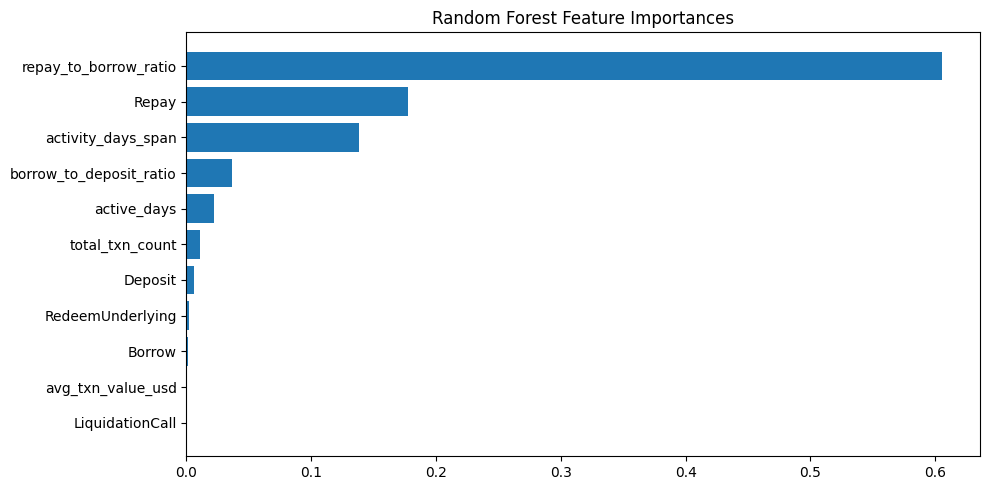

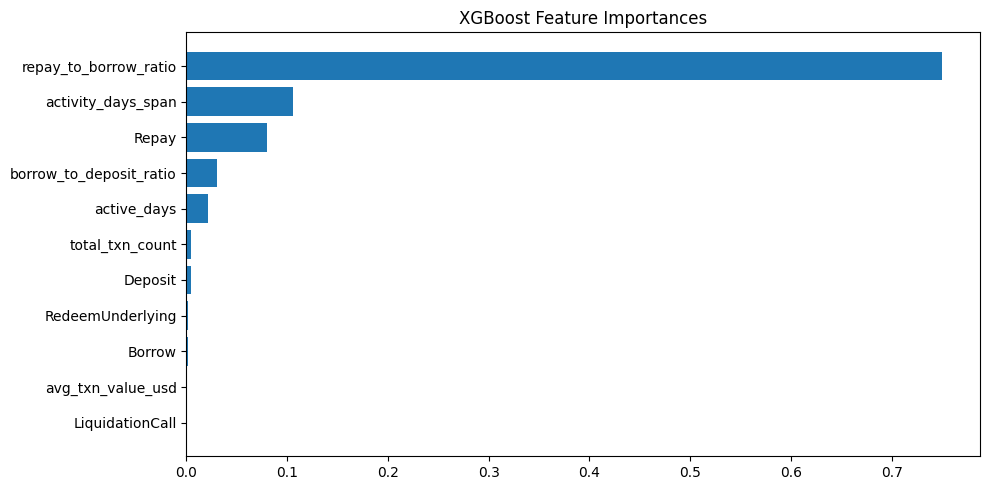

In [22]:
# === Step 7: Feature Importance Plot ===
def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    feature_names = X.columns

    sorted_idx = importances.argsort()
    plt.figure(figsize=(10, 5))
    plt.barh(feature_names[sorted_idx], importances[sorted_idx])
    plt.title(f"{model_name} Feature Importances")
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf, "Random Forest")
plot_feature_importance(xgbr, "XGBoost")

In [23]:
# === Step 8: Save Models ===
joblib.dump(rf, "random_forest_credit_model.pkl")
joblib.dump(xgbr, "xgboost_credit_model.pkl")

['xgboost_credit_model.pkl']